# Installations & Imports

In [ ]:
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

In [ ]:
%%capture
!pip install pymorphy2

In [ ]:
%%capture
!pip install -U pyLDAvis

In [ ]:
import requests
import re
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
import pymorphy2

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import chain

from textblob import TextBlob

import gensim
from gensim import corpora
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

import networkx as nx

# Создание корпуса

В качестве основы для корпуса мы выбрали сайт с отзывами на мобильные телефоны - helpix.ru. Отзывов там не так много, зато их можно спарсить, не столкнувшись с защитой, API-ключами, капчей и так далее.

In [ ]:
page = requests.get('https://helpix.ru/sitenews/opinion/last.html')
soup = BeautifulSoup(page.content, 'html.parser')
links = soup.find_all('a')
pattern = re.compile('/opinion')
urls = set()

for link in links:
  href = link.get('href')
  full_url = 'https://helpix.ru' + href
  if full_url not in urls and href and pattern.search(href) and not re.compile('go2admin').search(href) and not re.compile('site').search(href):
      urls.add(full_url)

In [ ]:
def get_review_text(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')

    p_tags = soup.find_all('p')

    review_text = ' '.join([p.get_text() for p in p_tags])

    return review_text

In [ ]:
corpus = []
phrase_to_remove = "14 Pro Max Apple Шрёдингера lazex-обзор Onyx Boox Nova Air C ..Цветной.. Обзор (8/10) Redmi Note 11 Pro+ ..Неоднозначный.. Обзор (8/10) Huawei Mate Xs 2 ..Гибкий.. Обзор (10/10) "

for url in urls:
  review_text = get_review_text(url)
  if review_text.startswith(phrase_to_remove):
        review_text = review_text[len(phrase_to_remove):]
  corpus.append(review_text)

In [ ]:
corpus[5]

'Как давно у вас это устройство? Устройство у меня уже очень давно, с 2014 года. Используете ли вы его до сих пор? Если нет - почему с ним расстались? Устройство находится в пользовании до сих пор и с\nмомента приобретения активно используется в каждодневном\nрежиме. Что нравится? Сильные стороны, достоинства. Сильные стороны - это, конечно, срок службы, за почти 8\nлет никак не изменилась скорость работы, т.е., что такое\nзависание при работе на этом ПК, я не сталкивалась.\nДалее батарея, в активном пользовании (например, работа\nв интернете, игры, просмотр видео в хорошем качестве и с\nбольшой яркостью) ее хватает на 2 дня. При прослушивании\nмузыки (беспроводные наушники) и чтении - около недели.\nДовольно хорошие камеры даже по сравнению с современными\nустройствами. Также дополнительный плюс - это возможность получить\nroot-права, что хороший бонус. Много памяти и не\nостаётся мусор от приложений в виде остатков файлов и\nкэша. Абсолютно совместим со всеми устройствами -\nноутбук,

In [ ]:
# количество текстов

len(corpus)

124

In [ ]:
# количество символов

len(''.join(str(i) for i in corpus))

964670

In [ ]:
# количество слов

print(len(' '.join(str(i) for i in corpus).split()))

141921


Отзывов немного, но они объёмные (в среднем почти по тысяче слов), поэтому закроем глаза на то, что они довольно немногочисленные. У нас есть почти 150 тысяч слов, что, на взгляд авторов, вполне достаточно для содержательного анализа.

# Предобработка

Наши тексты на русском языке, поэтому не будем пренебрегать библиотеками специально для русского языка (такими как pymorphy, natasha и др.)

Будем использовать лемматизацию, а не стемминг, так как в русском языке она работает лучше (мы можем помнить это из лабораторной по компьютерной лингвистике, но это объясняется просто наличием падежей, различных окончаний глаголов и других вещей, которых в английском нет или меньше).

Первые шаги, которые мы сделаем в предобработке, это приведём всё к нижнему регистру и удалим лишние символы (знаки препинания, переносы строки и так далее).

## Начало

In [ ]:
# удаление переносов строки

corpus = [i.replace('\n', ' ') for i in corpus]

In [ ]:
# нижний регистр

corpus_lower = [i.lower() for i in corpus]

In [ ]:
corpus_lower[5]

'как давно у вас это устройство? устройство у меня уже очень давно, с 2014 года. используете ли вы его до сих пор? если нет - почему с ним расстались? устройство находится в пользовании до сих пор и с момента приобретения активно используется в каждодневном режиме. что нравится? сильные стороны, достоинства. сильные стороны - это, конечно, срок службы, за почти 8 лет никак не изменилась скорость работы, т.е., что такое зависание при работе на этом пк, я не сталкивалась. далее батарея, в активном пользовании (например, работа в интернете, игры, просмотр видео в хорошем качестве и с большой яркостью) ее хватает на 2 дня. при прослушивании музыки (беспроводные наушники) и чтении - около недели. довольно хорошие камеры даже по сравнению с современными устройствами. также дополнительный плюс - это возможность получить root-права, что хороший бонус. много памяти и не остаётся мусор от приложений в виде остатков файлов и кэша. абсолютно совместим со всеми устройствами - ноутбук, 7, 9, 10 и 11

In [ ]:
# удалим знаки препинания и цифры

def remove_punctuation(text):
    return re.sub(r"[^\w\s\-]", "", text)

def remove_numbers(text):
    return re.sub(r"\d+", "", text)

In [ ]:
cleaned_corpus = [remove_punctuation(text) for text in corpus_lower]

In [ ]:
cleaned_corpus[5]

'как давно у вас это устройство устройство у меня уже очень давно с 2014 года используете ли вы его до сих пор если нет - почему с ним расстались устройство находится в пользовании до сих пор и с момента приобретения активно используется в каждодневном режиме что нравится сильные стороны достоинства сильные стороны - это конечно срок службы за почти 8 лет никак не изменилась скорость работы те что такое зависание при работе на этом пк я не сталкивалась далее батарея в активном пользовании например работа в интернете игры просмотр видео в хорошем качестве и с большой яркостью ее хватает на 2 дня при прослушивании музыки беспроводные наушники и чтении - около недели довольно хорошие камеры даже по сравнению с современными устройствами также дополнительный плюс - это возможность получить root-права что хороший бонус много памяти и не остаётся мусор от приложений в виде остатков файлов и кэша абсолютно совместим со всеми устройствами - ноутбук 7 9 10 и 11 андроид что не нравится слабые сто

In [ ]:
cleaned_corpus = [remove_numbers(text).strip() for text in cleaned_corpus]

In [ ]:
cleaned_corpus[5]

'как давно у вас это устройство устройство у меня уже очень давно с  года используете ли вы его до сих пор если нет - почему с ним расстались устройство находится в пользовании до сих пор и с момента приобретения активно используется в каждодневном режиме что нравится сильные стороны достоинства сильные стороны - это конечно срок службы за почти  лет никак не изменилась скорость работы те что такое зависание при работе на этом пк я не сталкивалась далее батарея в активном пользовании например работа в интернете игры просмотр видео в хорошем качестве и с большой яркостью ее хватает на  дня при прослушивании музыки беспроводные наушники и чтении - около недели довольно хорошие камеры даже по сравнению с современными устройствами также дополнительный плюс - это возможность получить root-права что хороший бонус много памяти и не остаётся мусор от приложений в виде остатков файлов и кэша абсолютно совместим со всеми устройствами - ноутбук    и  андроид что не нравится слабые стороны недоста

Разберёмся с дефисами. Если перед ними и после них стоит пробел, будем удалять, если нет - не будем. Также удалим лишние пробелы.

In [ ]:
def remove_extra_hyphens(text):
    text = re.sub(r"(?<=\s)-", "", text)
    text = re.sub(r"-(?=\s)", "", text)
    return text

def remove_extra_spaces(text):
    return text.replace('  ', ' ')

In [ ]:
final_cleaned_corpus = [remove_extra_spaces(remove_extra_hyphens(text)).replace('ё', 'е') for text in cleaned_corpus]

In [ ]:
final_cleaned_corpus[5]

'как давно у вас это устройство устройство у меня уже очень давно с года используете ли вы его до сих пор если нет почему с ним расстались устройство находится в пользовании до сих пор и с момента приобретения активно используется в каждодневном режиме что нравится сильные стороны достоинства сильные стороны это конечно срок службы за почти лет никак не изменилась скорость работы те что такое зависание при работе на этом пк я не сталкивалась далее батарея в активном пользовании например работа в интернете игры просмотр видео в хорошем качестве и с большой яркостью ее хватает на дня при прослушивании музыки беспроводные наушники и чтении около недели довольно хорошие камеры даже по сравнению с современными устройствами также дополнительный плюс это возможность получить root-права что хороший бонус много памяти и не остается мусор от приложений в виде остатков файлов и кэша абсолютно совместим со всеми устройствами ноутбук  и андроид что не нравится слабые стороны недостатки из недостатк

## Токенизация и стоп-слова

В качестве токенизации разделим тексты на отдельные слова.

In [ ]:
splitted_corpus = [i.split() for i in final_cleaned_corpus]

In [ ]:
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
russian_stopwords

{'а',
 'без',
 'более',
 'больше',
 'будет',
 'будто',
 'бы',
 'был',
 'была',
 'были',
 'было',
 'быть',
 'в',
 'вам',
 'вас',
 'вдруг',
 'ведь',
 'во',
 'вот',
 'впрочем',
 'все',
 'всегда',
 'всего',
 'всех',
 'всю',
 'вы',
 'где',
 'да',
 'даже',
 'два',
 'для',
 'до',
 'другой',
 'его',
 'ее',
 'ей',
 'ему',
 'если',
 'есть',
 'еще',
 'ж',
 'же',
 'за',
 'зачем',
 'здесь',
 'и',
 'из',
 'или',
 'им',
 'иногда',
 'их',
 'к',
 'как',
 'какая',
 'какой',
 'когда',
 'конечно',
 'кто',
 'куда',
 'ли',
 'лучше',
 'между',
 'меня',
 'мне',
 'много',
 'может',
 'можно',
 'мой',
 'моя',
 'мы',
 'на',
 'над',
 'надо',
 'наконец',
 'нас',
 'не',
 'него',
 'нее',
 'ней',
 'нельзя',
 'нет',
 'ни',
 'нибудь',
 'никогда',
 'ним',
 'них',
 'ничего',
 'но',
 'ну',
 'о',
 'об',
 'один',
 'он',
 'она',
 'они',
 'опять',
 'от',
 'перед',
 'по',
 'под',
 'после',
 'потом',
 'потому',
 'почти',
 'при',
 'про',
 'раз',
 'разве',
 'с',
 'сам',
 'свою',
 'себе',
 'себя',
 'сейчас',
 'со',
 'совсем',
 'так

In [ ]:
for w in ['это', 'какой', 'который', 'также', 'еще', 'очень', 'что-то']:
    russian_stopwords.add(w)

In [ ]:
def remove_stopwords(splitted_texts):
    filtered_corpus = []
    for splitted_text in splitted_texts:
        filtered_words = [word for word in splitted_text if word not in russian_stopwords]
        filtered_corpus.append(filtered_words)
    return filtered_corpus

In [ ]:
corpus_tokenized = remove_stopwords(splitted_corpus)

In [ ]:
corpus_tokenized[5]

['давно',
 'устройство',
 'устройство',
 'давно',
 'года',
 'используете',
 'сих',
 'пор',
 'почему',
 'расстались',
 'устройство',
 'находится',
 'пользовании',
 'сих',
 'пор',
 'момента',
 'приобретения',
 'активно',
 'используется',
 'каждодневном',
 'режиме',
 'нравится',
 'сильные',
 'стороны',
 'достоинства',
 'сильные',
 'стороны',
 'срок',
 'службы',
 'лет',
 'никак',
 'изменилась',
 'скорость',
 'работы',
 'те',
 'такое',
 'зависание',
 'работе',
 'пк',
 'сталкивалась',
 'далее',
 'батарея',
 'активном',
 'пользовании',
 'например',
 'работа',
 'интернете',
 'игры',
 'просмотр',
 'видео',
 'хорошем',
 'качестве',
 'большой',
 'яркостью',
 'хватает',
 'дня',
 'прослушивании',
 'музыки',
 'беспроводные',
 'наушники',
 'чтении',
 'около',
 'недели',
 'довольно',
 'хорошие',
 'камеры',
 'сравнению',
 'современными',
 'устройствами',
 'дополнительный',
 'плюс',
 'возможность',
 'получить',
 'root-права',
 'хороший',
 'бонус',
 'памяти',
 'остается',
 'мусор',
 'приложений',
 'виде'

## Лемматизация

In [ ]:
morph = pymorphy2.MorphAnalyzer()

In [ ]:
def lemmatize_tokens(corpus_tokenized):
    lemmatized_corpus = []
    for tokens in corpus_tokenized:
        lemmatized_tokens = [morph.parse(token)[0].normal_form for token in tokens]
        lemmatized_corpus.append(lemmatized_tokens)
    return lemmatized_corpus

In [ ]:
corpus_lemmatized = lemmatize_tokens(corpus_tokenized)

In [ ]:
corpus_lemmatized[5]

['давно',
 'устройство',
 'устройство',
 'давно',
 'год',
 'использовать',
 'сей',
 'пора',
 'почему',
 'расстаться',
 'устройство',
 'находиться',
 'пользование',
 'сей',
 'пора',
 'момент',
 'приобретение',
 'активно',
 'использоваться',
 'каждодневный',
 'режим',
 'нравиться',
 'сильный',
 'сторона',
 'достоинство',
 'сильный',
 'сторона',
 'срок',
 'служба',
 'год',
 'никак',
 'измениться',
 'скорость',
 'работа',
 'тот',
 'такой',
 'зависание',
 'работа',
 'пк',
 'сталкиваться',
 'далее',
 'батарея',
 'активный',
 'пользование',
 'например',
 'работа',
 'интернет',
 'игра',
 'просмотр',
 'видео',
 'хороший',
 'качество',
 'большой',
 'яркость',
 'хватать',
 'день',
 'прослушивание',
 'музыка',
 'беспроводный',
 'наушник',
 'чтение',
 'около',
 'неделя',
 'довольно',
 'хороший',
 'камера',
 'сравнение',
 'современный',
 'устройство',
 'дополнительный',
 'плюс',
 'возможность',
 'получить',
 'root-право',
 'хороший',
 'бонус',
 'память',
 'оставаться',
 'мусор',
 'приложение',
 'вид

In [ ]:
corpus_lemmatized = remove_stopwords(corpus_lemmatized)

Выглядит адекватно. Перейдём к частотному анализу.

# Частотный анализ

In [ ]:
all_words = list(chain(*corpus_lemmatized))

## Униграммы

In [ ]:
unigram_freq = Counter(all_words)
unigram_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unigram_freq)

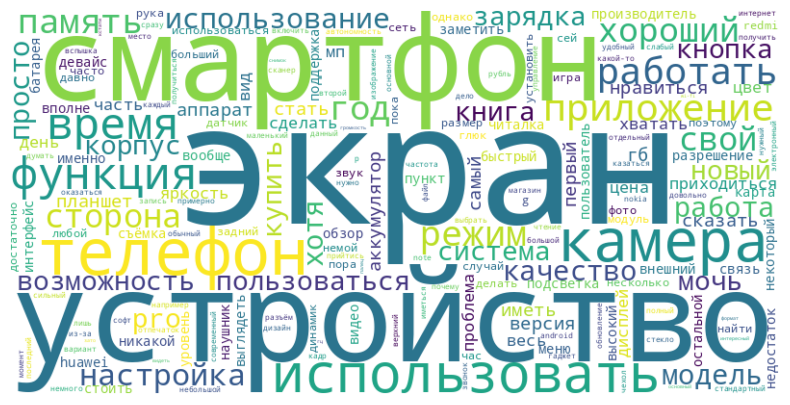

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(unigram_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Как и ожидалось, одними из самых популярных слов являются "экран", "телефон", "смартфон" и другие слова, связанные тематически с телефонами. Также заметно большое слово "хороший" - вероятно, это означает, что тональность отзывов на сайте в основном положительная.

## Биграммы

In [ ]:
bigrams = list(nltk.bigrams(all_words))
bigram_strings = [' '.join(bigram) for bigram in bigrams]
bigram_freq = Counter(bigram_strings)
bigram_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq)

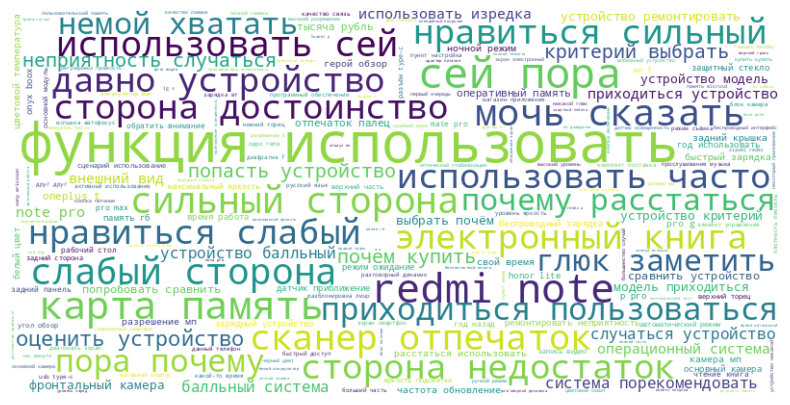

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(bigram_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Среди самых популярных биграмм можно заметить модели смартфонов - Redmi Note, Note Pro, Pro Max и другие. Также часто встречаются "карта памяти", "электронная книга" и другие словосочетания, которыми называются электронные товары. Крупно мы видим "сильная сторона" и "слабая сторона" - слова, характерные для отзывов. Видимо, рецензии достаточно конструктивные и подробные.

# Анализ тональности

Для анализа тональности попробуем библиотеку TextBlob.

In [ ]:
def analyze_sentiment(corpus_lemmatized):
    sentiment_dict = {}

    for tokens in corpus_lemmatized:
        text = ' '.join(tokens)
        blob = TextBlob(text)
        sentiment = 'positive' if blob.sentiment.polarity > 0 else 'negative' if blob.sentiment.polarity < 0 else 'neutral'
        sentiment_dict[text] = sentiment

    return sentiment_dict

In [ ]:
sentiment_dict = analyze_sentiment(corpus_lemmatized)

In [ ]:
def get_example_text(sentiment):
    for text, sent in sentiment_dict.items():
        if sent == sentiment:
            return text
    return None

neutral_example = get_example_text('neutral')
positive_example = get_example_text('positive')
negative_example = get_example_text('negative')

print("Пример нейтрального текста:")
print(neutral_example)
print()

print("Пример позитивного текста:")
print(positive_example)
print()

print("Пример негативного текста:")
print(negative_example)

Пример нейтрального текста:
давно устройство купить апрель использовать сей пора почему расстаться ходить удобный смартфон больший экран яркий цветной выходить интернет сима-карта попасть устройство выбирать долго днс критерий выбрать внешний вид почём купить днс нравиться сильный сторона достоинство внешний вид размер экран нравиться слабый сторона недостаток долго думать тихий разговорный динамик немой хватать отпечаток палец nfc функция использовать часто интернет звонок смс функция использовать изредка калькулятор радио функция использовать блютуз вай-фай приходиться устройство ремонтировать слава бог пока неприятность случаться устройство видеть сеть перезагрузить увидеть глюк заметить долго думать листать попробовать сравнить устройство модель приходиться пользоваться samsung j prime мочь сказать нормальный телефон среднее пользователь оценить устройство балльный система порекомендовать балл рекомендовать аделин

Пример позитивного текста:
последний время планшет словно получить 

In [ ]:
sentiment_counts = {}
for sentiment in sentiment_dict.values():
    if sentiment in sentiment_counts:
        sentiment_counts[sentiment] += 1
    else:
        sentiment_counts[sentiment] = 1

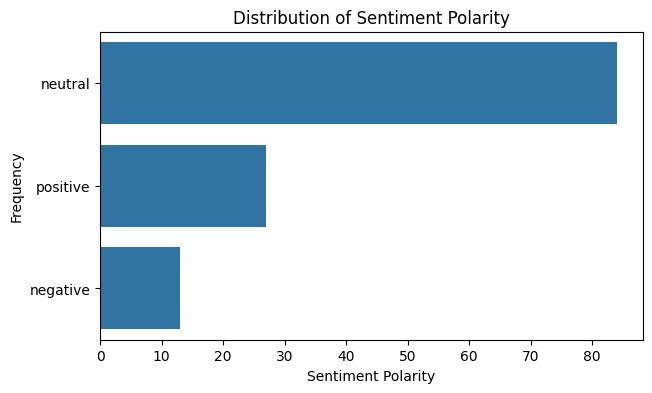

In [ ]:
sentiments = list(sentiment_dict.values())
plt.figure(figsize=(7, 4))
sns.countplot(sentiments)
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

# Тематическое моделирование

Для тематического моделирования воспользуемся методом LDA (Latent Dirichlet Allocation), а именно - его реализацией из библиотеки gensim, а для интерактивной визуализации используем библиотеку pyLDAvis.

В качестве количества тем возьмём 5.

In [ ]:
pyLDAvis.enable_notebook()

dictionary = corpora.Dictionary(corpus_lemmatized)
corp = [dictionary.doc2bow(text) for text in corpus_lemmatized]

lda_model = gensim.models.LdaModel(corp, num_topics=5, id2word=dictionary, passes=15)

In [ ]:
lda_display = gensimvis.prepare(lda_model, corp, dictionary)

In [ ]:
pyLDAvis.display(lda_display)

# Графовая модель корпуса

In [ ]:
import networkx as nx

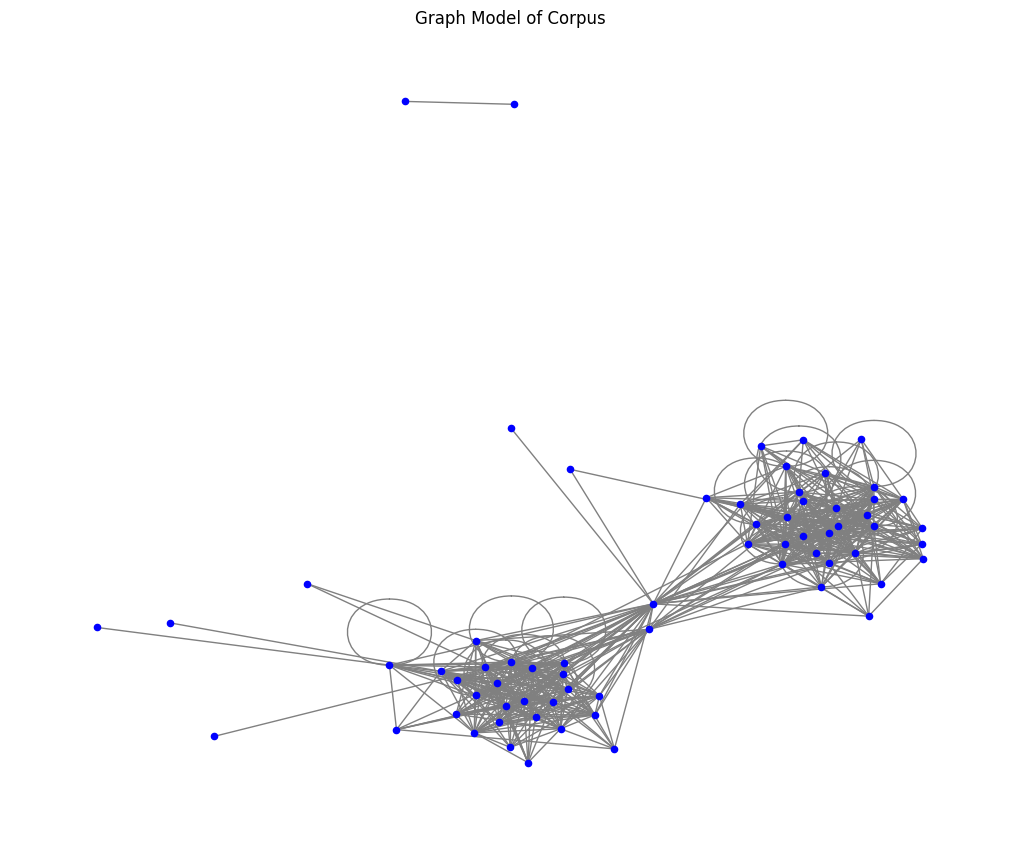

In [ ]:
G = nx.Graph()

for bigram, freq in bigram_freq.items():
    G.add_edge(bigram[0], bigram[1], weight=freq)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.15, iterations=20)
nx.draw(G, pos, node_size=20, node_color='blue', edge_color='grey', with_labels=False)
plt.title('Graph Model of Corpus')
plt.show()